In [ ]:
from skipgram.read import read_sequential, destructure, read_vocab
from skipgram.model import Embeddings
from bayesian_skipgram.model import BayesianSkipgram
from bayesian_skipgram.read import read_context_wise
from embed_align.model import AlignedEmbeddings
from predict import write_predictions
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import numpy as np

# Negative Sampling Skip Gram

### Training

In [10]:
EMBEDDINGS_SIZE = 100
FILE = './data/dev.en'
vocab = {w: i for i, w in enumerate(read_vocab(FILE, []))}
inv_vocab = {i: w for i, w in enumerate(read_vocab(FILE, []))}
model = Embeddings(EMBEDDINGS_SIZE, len(vocab))
optimizer = optim.SparseAdam(model.parameters(), lr = 0.01)

In [11]:
def epoch():
    losses = []
    for x, y in read_sequential(FILE, 2, [], vocab, 500):
        optimizer.zero_grad()
        loss = model(x, y)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.mean(torch.Tensor(losses))

losses = [epoch() for i in range(100)]

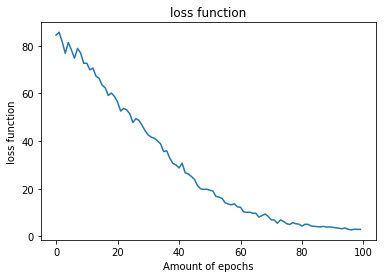

In [12]:
plt.plot(losses)
plt.title('loss function')
plt.xlabel('Amount of epochs')
plt.ylabel('loss function')
plt.show()

In [13]:
import csv

def strip_last_bit(word):
    return word[:word.index('.')]
    
def write_predictions(testfile, model, vocab, inv_vocab):
    with open(testfile) as infile:
        with open('lst/1predictions.txt', 'w') as outfile:
            test = csv.reader(infile, delimiter='\t')
            for target, sentence_id, position, sentence in test:
                candidates, scores = model.most_similar(vocab.get(strip_last_bit(target), 0), 20)
                row = '\t'.join(['#WHAT?', target, str(sentence_id)])
                row = '\t{0} {1}'.format(target, str(sentence_id))
                target = strip_last_bit(target)
                line = ['\t' + target + ' ' + str(sentence_id)]
                for i, score in zip(candidates, scores):
                    line.append(inv_vocab[i] + ' '  + str(score))
                    row += "\t{0} {1}".format(inv_vocab[i], str(score))
                outfile.write(row + '\n')


write_predictions('lst/lst_test.preprocessed', model, vocab, inv_vocab)

### Qualitative Examples

In [18]:
print('complex ->', inv_vocab[model.most_similar(vocab.get('complex', 0), 2)[0][0]])
print('prostitute ->', inv_vocab[model.most_similar(vocab.get('prostitute', 0), 2)[0][0]])
print('streets ->', inv_vocab[model.most_similar(vocab.get('streets', 0), 2)[0][0]])
print('hi ->', inv_vocab[model.most_similar(vocab.get('hi', 0), 2)[0][0]])

complex -> when
prostitute -> ensure
streets -> 49
hi -> at


# Bayesian Skipgram

In [20]:
FILE = './data/dev.en'

vocab = {w: i for i, w in enumerate(read_vocab(FILE, []))}
inv_vocab = {i: w for i, w in enumerate(read_vocab(FILE, []))}

model = BayesianSkipgram(50, len(vocab))
loss_function = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [21]:
def epoch():
    losses = []
    for word, context in read_context_wise(FILE, 2, []):
        word_index = torch.LongTensor([vocab[word]])
        optimizer.zero_grad()
        model.zero_grad()
        context_indices = torch.LongTensor([vocab[i] for i in context])
        loss = model(word_index, context_indices)
        losses.append(loss)
        loss.backward()
        optimizer.step()
    return torch.mean(torch.Tensor(losses))

losses = [epoch() for _ in range(10)]

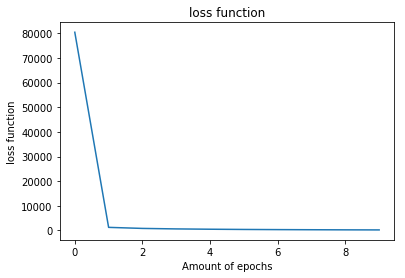

In [9]:
plt.plot(losses)
plt.title('loss function')
plt.xlabel('Amount of epochs')
plt.ylabel('loss function')
plt.show()

In [22]:
print('Minister ->', inv_vocab[model.most_similar(vocab.get('Minister', 0))[0][1]])
print('aware ->', inv_vocab[model.most_similar(vocab.get('aware', 0))[0][1]])
print('British ->', inv_vocab[model.most_similar(vocab.get('British', 0))[0][1]])
print('streets ->', inv_vocab[model.most_similar(vocab.get('streets', 0))[0][1]])

Minister -> tax
aware -> laws
British -> bail
streets -> .


# Embed Align

In [5]:
from embed_align.read import read

FILE_L1 = './data/dev.en'
FILE_L2 = './data/dev.fr'

vocab_l1 = {w: i for i, w in enumerate(read_vocab(FILE_L1, []))}
vocab_l2 = {w: i for i, w in enumerate(read_vocab(FILE_L2, []))}

model = AlignedEmbeddings(12, len(vocab_l1), len(vocab_l2), 10)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

def epoch():
    losses = []
    for l1, l2 in read(FILE_L1, FILE_L2):
        optimizer.zero_grad()
        model.zero_grad()
        l1_tensor = torch.LongTensor([vocab_l1[w] for w in l1.split()])
        l2_tensor = torch.LongTensor([vocab_l2[w] for w in l2.split()])

        loss = model(l1_tensor, l2_tensor)
        loss.backward()
        losses.append(loss)
        optimizer.step()
    return torch.mean(torch.Tensor(losses))
    
losses = [epoch() for _ in range(10)]

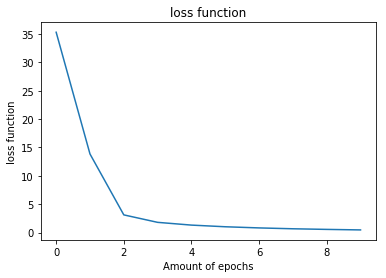

In [6]:
plt.plot(losses)
plt.title('loss function')
plt.xlabel('Amount of epochs')
plt.ylabel('loss function')
plt.show()